In [4]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
import anndata as ad
#from scib_metrics.benchmark import Benchmarker

# 定义包含 .h5ad 文件的目录
data_dir = "/data/work/final/02_integrate_sample/single_samples_delete_genes"

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
#save_dir = '/data/work/final/sample/integrate/delete_cells'

h5ad_files = [f for f in os.listdir(data_dir) if f.endswith('.h5ad')]

# 读取并添加 batch 信息到每个 AnnData 对象
adatas = []
for file in h5ad_files:
    # 读取每个 .h5ad 文件
    adata = sc.read(os.path.join(data_dir, file))
    #adata.layers["counts"] = adata.X.copy()
    # 添加 batch 信息（文件名去掉 .h5ad 后缀）
    #batch_name = os.path.splitext(file)[0]
    #adata.obs['batch'] = batch_name
    
    # 将带有 batch 信息的 AnnData 对象添加到列表中
    adatas.append(adata)

# 合并
adata_combined = ad.concat(adatas, join='outer', label='sample', keys=[os.path.splitext(f)[0] for f in h5ad_files])

# 进行标准化和预处理（如果需要）
adata_combined.layers["counts"] = adata_combined.X.copy()
#sc.pp.normalize_total(adata_combined, target_sum=1e4)
#sc.pp.log1p(adata_combined)

patient_data = {
    "1125687": "1125687_Female_12",
    "1125175": "1125175_Male_65",
    "662": "1127662_Female_58",  # 性别缺失，标记为 Unknown
    "868": "1127868_Male_18",
    "781": "1127781_Male_49",
    "1174019": "1174019_Female_70",
    "1174264": "1174264_Male_62",
    "1174369": "1174369_Female_62",
    "1175196": "1175196_Male_16",
    "1013506": "1013506_Male_78",
    "1175793": "1175793_Male_77",
    "1175525": "1175525_Male_71",
    "1111272": "1111272_Female_67",
    "1077557": "1177557_Male_16",
    "1177968": "1177968_Female_65",
    "1143448": "1143448_Female_71",
    "1177671": "1177671_Female_63",
    "1178402": "1178402_Female_83",
    "117": "1178552_Male_13",
    "1130425": "1130425_Female_67",
    "1182051": "1182051_Female_71",
    "1181745": "1181745_Male_64",
    "1182992": "1182992_Male_44",
    "1179925": "1179925_Female_43",
    "1184011": "1184011_Female_66",
    "1185335": "1185335_Male_54",
    "1184859": "1184859_Female_60",
    "1184799": "1184799_Female_64",
    "1185577": "1185577_Female_70",
    "1185896": "1185896_Female_76",
    "1185833": "1185833_Male_70",
    "1185580": "1185580_Female_71",
    "1185962": "1185962_Female_67",
    "1185759": "1185759_Male_26",
    "1186145": "1186145_Male_49",
    "1186600": "1186600_Male_71",
    "1186135": "1186135_Female_64",
    "1186193": "1186193_Female_66"
}
adata_combined.obs['sample_all'] = adata_combined.obs['sample'].map(patient_data)

ctap_dict = {
    '1125687_Female_12': 12,
    '1125175_Male_65': 65,
    '1127662_Female_58': 58,
    '1127868_Male_18': 18,
    '1127781_Male_49': 49,
    '1174019_Female_70': 70,
    '1174264_Male_62': 62,
    '1174369_Female_62': 62,
    '1175196_Male_16': 16,
    '1013506_Male_78': 78,
    '1175793_Male_77': 77,
    '1175525_Male_71': 71,
    '1111272_Female_67': 67,
    '1177557_Male_16': 16,
    '1177968_Female_65': 65,
    '1143448_Female_71': 71,
    '1177671_Female_63': 63,
    '1178402_Female_83': 83,
    '1178552_Male_13': 13,
    '1130425_Female_67': 67,
    '1182051_Female_71': 71,
    '1181745_Male_64': 64,
    '1182992_Male_44': 44,
    '1179925_Female_43': 43,
    '1184011_Female_66': 66,
    '1185335_Male_54': 54,
    '1184859_Female_60': 60,
    '1184799_Female_64': 64,
    '1185577_Female_70': 70,
    '1185896_Female_76': 76,
    '1185833_Male_70': 70,
    '1185580_Female_71': 71,
    '1185962_Female_67': 67,
    '1185759_Male_26': 26,
    '1186145_Male_49': 49,
    '1186600_Male_71': 71,
    '1186135_Female_64': 64,
    '1186193_Female_66': 66
}
adata_combined.obs['age'] = adata_combined.obs['sample_all'].map(ctap_dict)

# 定义年龄分组函数
def age_group(age):
    if age < 40:
        return 'young'
    elif 40 <= age < 60:
        return 'middle-aged'
    else:
        return 'old'

# 应用分组函数创建新列
adata_combined.obs['age_period'] = adata_combined.obs['age'].map(age_group)

sc.pp.highly_variable_genes(
    adata_combined,
    flavor="seurat_v3",
    n_top_genes=3000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

# 设置 scVI 的 AnnData 格式
scvi.model.SCVI.setup_anndata(adata_combined, layer="counts", batch_key="batch",categorical_covariate_keys=["experiment"])

print("数据整合完成，已准备好用于 scVI 的后续分析。")

Seed set to 0


Last run with scvi-tools version: 1.1.6.post2

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


数据整合完成，已准备好用于 scVI 的后续分析。

In [5]:
vae = scvi.model.SCVI(adata_combined, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Epoch 14/14: 100%|██████████| 14/14 [13:40<00:00, 57.35s/it, v_num=1, train_loss_step=585, train_loss_epoch=550]

`Trainer.fit` stopped: `max_epochs=14` reached.


Epoch 14/14: 100%|██████████| 14/14 [13:40<00:00, 58.60s/it, v_num=1, train_loss_step=585, train_loss_epoch=550]


In [6]:
adata_combined.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata_combined, use_rep="X_scVI")
sc.tl.leiden(adata_combined)

/tmp/ipykernel_1848/80736710.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined)


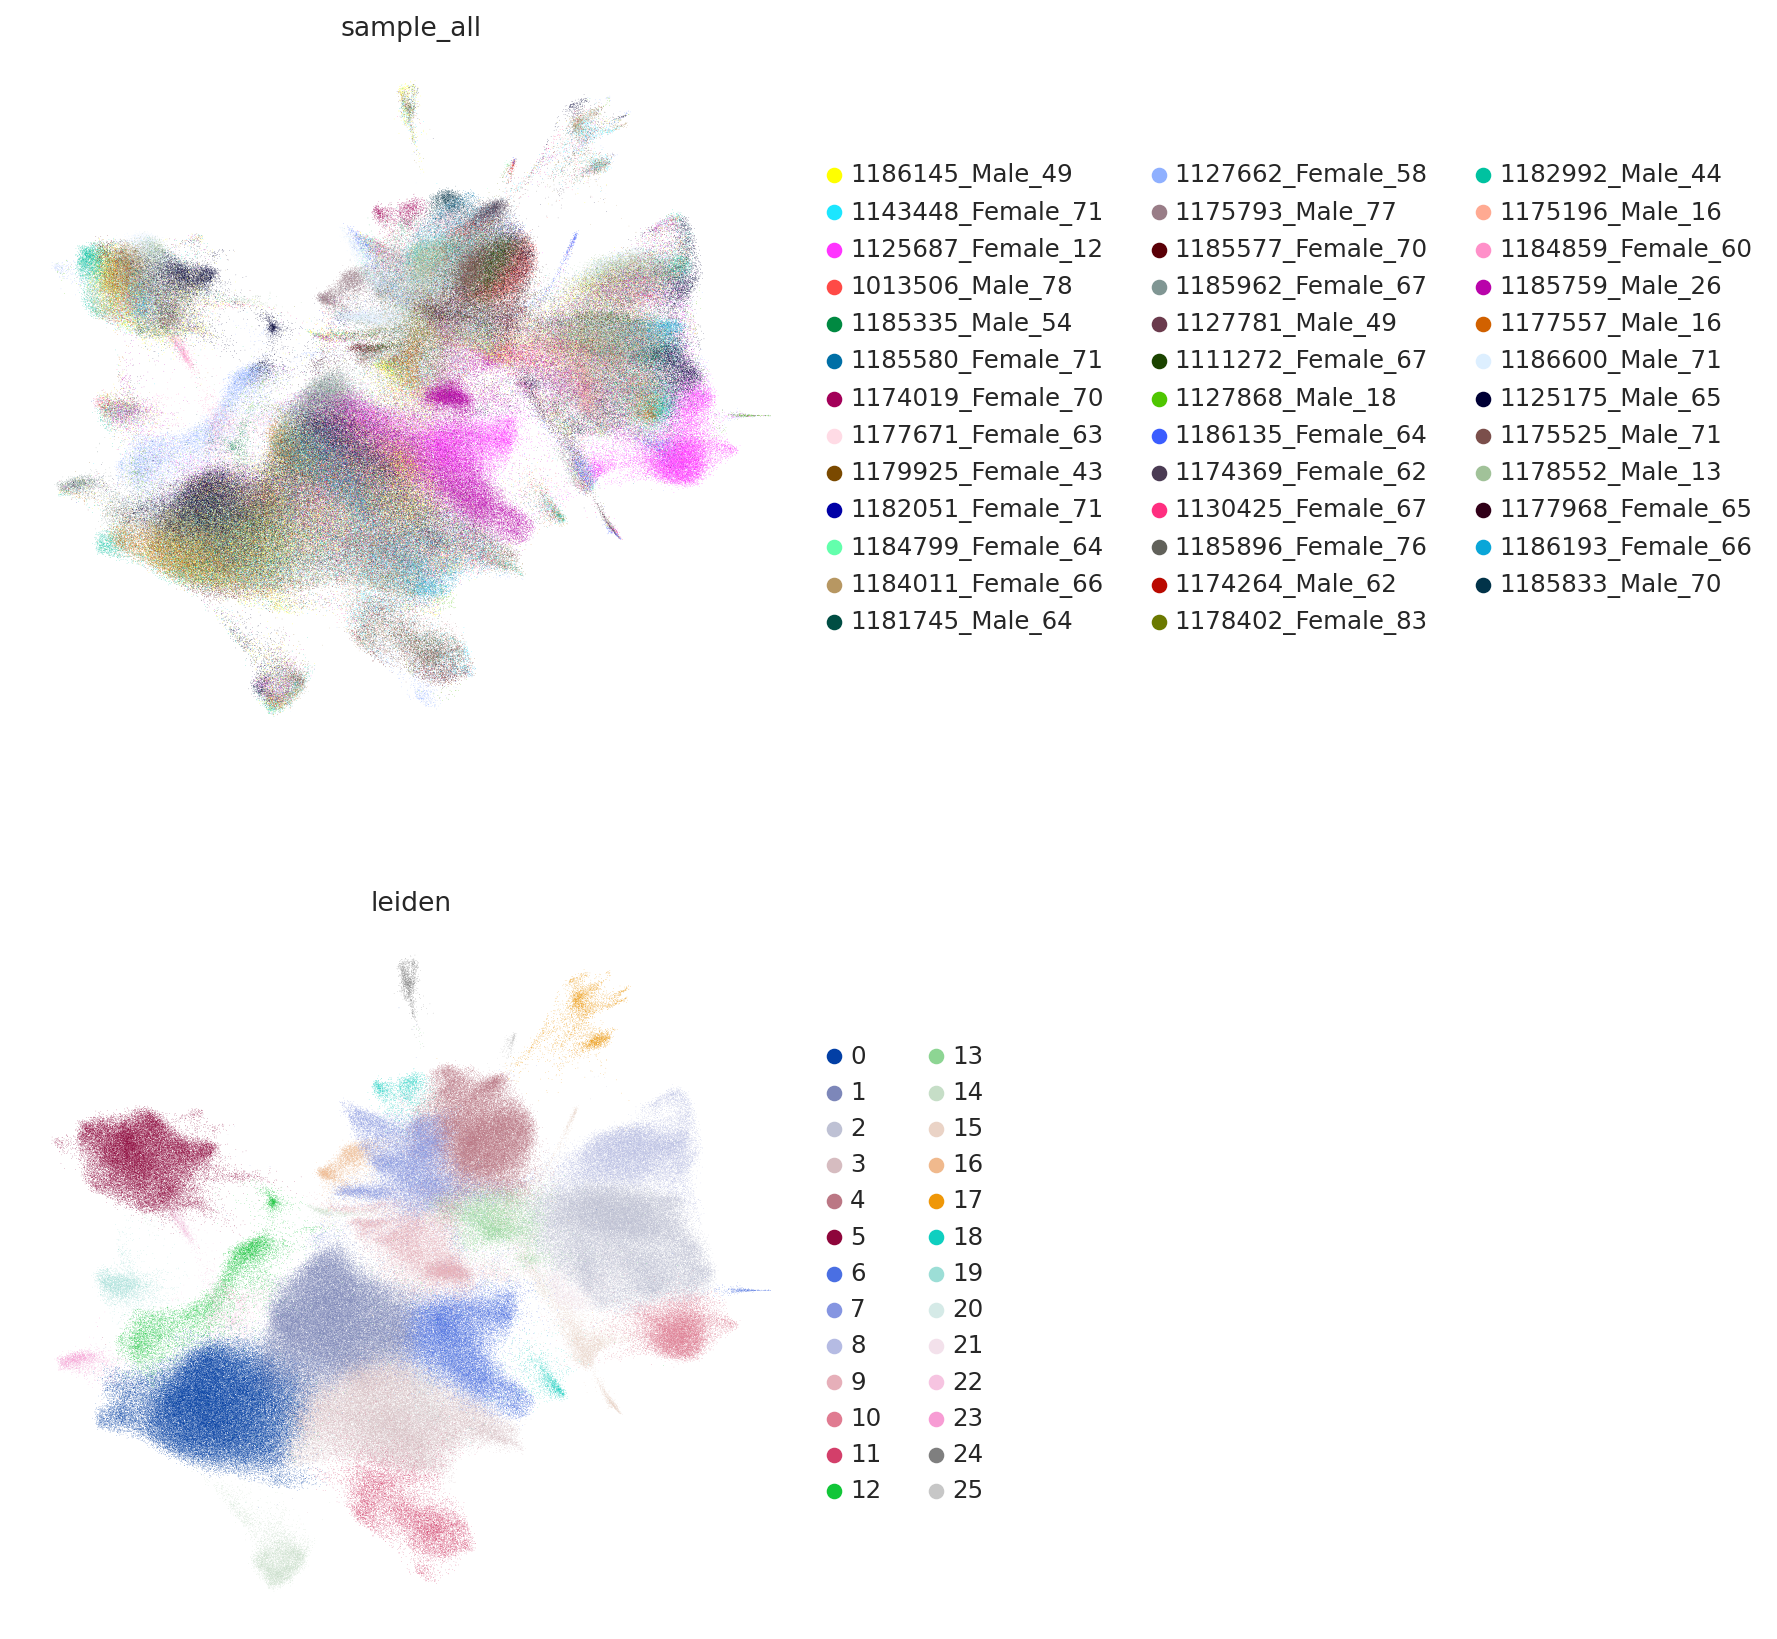

In [7]:
sc.tl.umap(adata_combined)
sc.pl.umap(
    adata_combined,
    color=["sample_all", "leiden"],
    frameon=False,
    ncols=1,
)

In [8]:
adata_combined

AnnData object with n_obs × n_vars = 563738 × 3000
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'experiment', 'sample_all', 'age', 'age_period', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'leiden', 'umap', 'sample_all_colors', 'leiden_colors'
    obsm: '_scvi_extra_categorical_covs', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [9]:
del adata_combined.X
adata_combined.write('/data/work/final/02_integrate_sample/integrate/new/OA_integrate.h5ad')

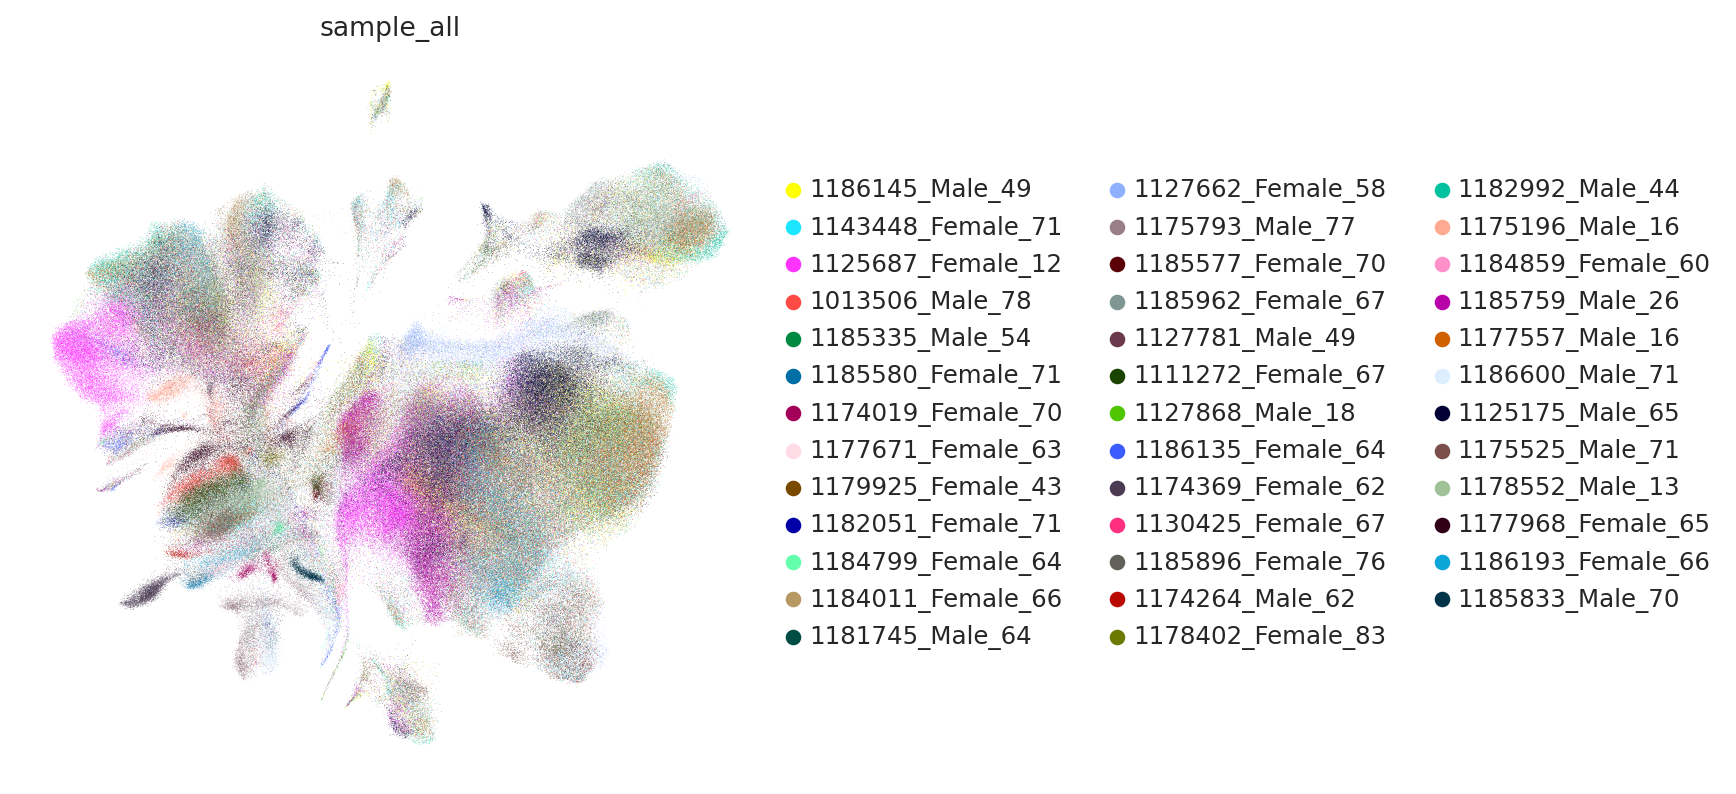

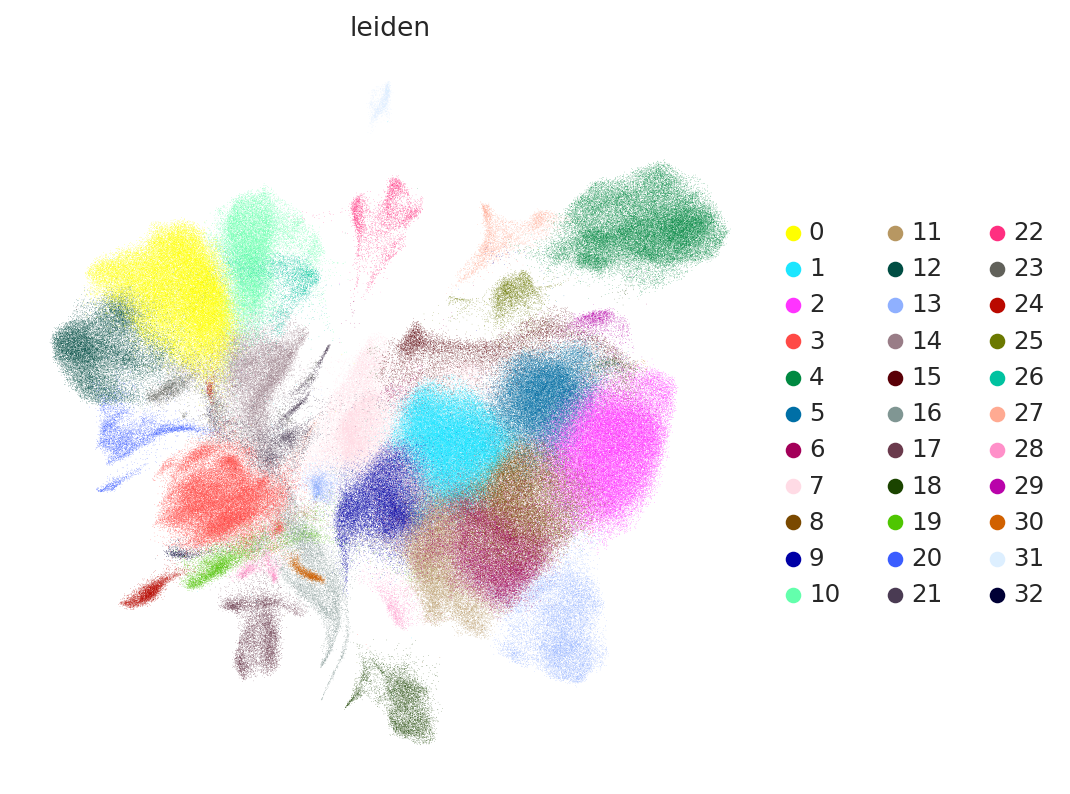

In [ ]:
#sc.pp.neighbors(adata_combined, use_rep='X_scVI', n_pcs=30)
#sc.tl.umap(adata_combined, random_state=42)
#sc.pl.umap(adata_combined,color='sample_all')
#sc.pl.umap(adata_combined,color='leiden')